<a href="https://colab.research.google.com/github/gingerchien/QuantHub/blob/main/QuantumQuants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
# !pip install -U ipython
# !pip install yfinance
# !pip install wrds
# !pip install swig
# #!pip install pyportfolioopt
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install stockstats

# #Google Colab runs on Linux environment, so download TA-Lib C library first
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# %cd ..
# !rm -rf ta-lib ta-lib-0.4.0-src.tar.gz

# #Then install the Python wrapper using pip
# !pip install TA-Lib

# !pip install gymnasium
# !pip install stable_baselines3
# !pip install pyfolio

# #Installing Optuna
# !pip3 install optuna

# #Install Vectorbt
# !pip install vectorbt

In [ ]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from stockstats import StockDataFrame as Sdf

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise


import warnings
warnings.filterwarnings("ignore")
import os
import time
import joblib

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

%matplotlib inline

from stable_baselines3.common.logger import configure
from pprint import pprint
import itertools

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from copy import deepcopy

import pyfolio
from pyfolio import timeseries

import yfinance as yf
import vectorbt as vbt
import talib

import random
from stable_baselines3.common.utils import set_random_seed
os.environ['PYTHONHASHSEED']=str(42)

random.seed(42)
set_random_seed(42)
np.random.seed(42)

# Indicator/Normalization Definitions

In [ ]:
#config

#Indicator to pass in **env_kwgs to create state space
INDICATORS = ['norm_vol_diff','lower_wick_ratio', 'body_ratio', 'upper_wick_ratio', 'rsi_5', 'ma_diff_ratio','norm_vix', 'norm_turb']

#Columns chosen to be normalized by Robust Scaler and MinMax Scaler in the deep autoencoder. Close price is not normalized as it is required for calculation of total asset and reward and will be added back into the normalized dataset.
columns_norm = ['norm_vol_diff','lower_wick_ratio', 'body_ratio', 'upper_wick_ratio', 'rsi_5', 'ma_diff_ratio','norm_vix', 'norm_turb']


# Config Info for Project

In [ ]:
#config
DATA_SAVE_DIR = "datasets"
TRAINED_MODEL_DIR = "trained_models"
TENSORBOARD_LOG_DIR = "tensorboard_log"
RESULTS_DIR = "results"


# date format: '%Y-%m-%d'
DATA_START_DATE = '2018-01-01'
TRAIN_START_DATE = "2018-02-01"  # bug fix: set Monday right, start date set 2014-01-01 ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1658 and the array at index 1 has size 1657
TRAIN_END_DATE = "2021-12-31"

TEST_START_DATE = "2022-01-01"
TEST_END_DATE = "2023-12-01"

TRADE_START_DATE = "2022-01-01"
TRADE_END_DATE = "2023-12-01"

# "./" will be added in front of each directory
def check_and_make_directories(directories: list[str]):
    for directory in directories:
        if not os.path.exists("./" + directory):
            os.makedirs("./" + directory)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

#Models
MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

# Default Model Parameters, These will be compared to the tuned parameters later on
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}

PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
}
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}

TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}

SAC_PARAMS = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
ERL_PARAMS = {
    "learning_rate": 3e-5,
    "batch_size": 2048,
    "gamma": 0.985,
    "seed": 312,
    "net_dimension": 512,
    "target_step": 5000,
    "eval_gap": 30,
    "eval_times": 64,  # bug fix:KeyError: 'eval_times' line 68, in get_model model.eval_times = model_kwargs["eval_times"]
}
RLlib_PARAMS = {"lr": 5e-5, "train_batch_size": 500, "gamma": 0.99}

#FinRL Classes/Methods

## Stock Trading Env with OpenAI Gym

In [ ]:
#Stock Trading Env
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int, #number of stocks in the environment
        hmax: int, # Maximum number of shares to buy or sell in one transaction..
        initial_amount: int, #Starting cash for the portfolio
        num_stock_shares: list[int], #List containing the number of shares for each stock.
        buy_cost_pct: float, #list[float]#Lists of percentages for buying and selling costs.
        sell_cost_pct: float, #list[float]
        reward_scaling: float, #Factor to scale the reward.
        state_space: int, #Sizes of the state and action spaces.
        action_space: int,
        tech_indicator_list: list[str], #List of technical indicators used in the state.
        turbulence_threshold = 0.18, #Threshold for market turbulence.
        risk_indicator_col= 'norm_vix',
        make_plots: bool = True,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",

    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        #print(f"type of self.buy_cost_pct: {type(self.buy_cost_pct)}, value: {self.buy_cost_pct}")

        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))#efine the shape and bounds of actions and observations in the Gym environment.
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state() #setting up the initial state of the environment.

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True #index is the specific stock to be sold, action is the amount of stock to sell
            ):  #This condition checks if the stock represented by index is currently able to be sold. The expression self.state[index + 2 * self.stock_dim + 1] refers to a specific value in the state array that
                #indicates whether the stock is tradable.
                # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                #print("Index:", index)
                #print("Action to sell:", action)
                #print('stock_dim', self.stock_dim)
                #print('self.state', self.state )
                if self.state[index + self.stock_dim + 1] > 0: #This condition checks if the agent owns any shares of the stock.
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1] # Determines the number of shares to sell. Minimum of the absolute value of the action and the number of shares the agent currently holds.
                    )
                    #print("Number of shares to sell:", sell_num_shares)
                    sell_amount = (#Calculates the total cash received from selling
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct)
                    )
                    # update balance
                    self.state[0] += sell_amount # Updates the agent's cash balance by adding the sell_amount.

                    self.state[index + self.stock_dim + 1] -= sell_num_shares #Decreases the number of shares the agent holds after the sale.
                    self.cost += ( #Accumulates the cost of selling.
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct
                    )
                    self.trades += 1# Increments the total number of trades conducted.
                else:
                    sell_num_shares = 0 # This handles the case where the agent does not have any shares to sell or the stock cannot be sold due to restrictions.
            else:
                sell_num_shares = 0

            return sell_num_shares # returns the number of shares sold.

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:#This checks if the agent owns any shares of the stock.
                      #This checks if the current price of the stock (denoted by self.state[index + 1]) is greater than zero, meaning the stock has a valid, positive price.
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]# Set the number of shares to sell to the total number of shares owned.
                        sell_amount = (#Calculate the total cash received from selling these shares, accounting for the selling cost
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct)
                        )
                        # update balance
                        self.state[0] += sell_amount #Update the total cost (self.cost) incurred from the sale and increment the trade count (self.trades).
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()#If the current turbulence is below the threshold or if no threshold is defined, the normal selling process (_do_sell_normal()) is executed.
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                #print("Index:", index)
                #print("Action to buy:", action)

                # Calculate the denominator and ensure it is positive and non-zero
                #print(f"type of self.state[index + 1]: {type(self.state[index + 1])}, value: {self.state[index + 1]}")
                #print(f"type of self.buy_cost_pct: {type(self.buy_cost_pct)}, value: {self.buy_cost_pct}")

                # Ensure buy_cost_pct is a numeric value
                if not isinstance(self.buy_cost_pct, (float, int)):
                    self.buy_cost_pct = self.buy_cost_pct[0]
                    #raise TypeError(f"Expected buy_cost_pct to be a float or int, got {type(self.buy_cost_pct)}")
                denominator = self.state[index + 1] * (1 + self.buy_cost_pct)
                if denominator <= 0:
                    #print(f"Denominator is non-positive ({denominator}). Unable to buy.")
                    return 0

                available_amount = self.state[0] // denominator  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                #print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                #print("Number of shares to buy:", buy_num_shares)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        #print('Actions at the start of step method', actions)
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.4f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            #print('actions, check if initially scaled between 0 to 1', actions)
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1

            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
                #print('initiate state', state)
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self): #create a vectorized environment. DummyVecEnv is a class from stable_baselines which is used to create a vectorized wrapper for muiltiple environments.Vectorized environments are a way to run multiple instances of an environment in parallel helping
    #to speed up training for RL algorithms
        e = DummyVecEnv([lambda: self]) #Wrapping the current environment instance into a vectorized environment
        obs = e.reset() #resets the environment e and stores the initial observation returned by the environment into the variable obs. This initial observation is then used by the RL agent to make its first decision in the new episode
        return e, obs

## TensorboardCallback

In [ ]:
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])

        except BaseException as error:
            try:
                self.logger.record(key="train/reward", value=self.locals["reward"][0])

            except BaseException as inner_error:
                # Handle the case where neither "rewards" nor "reward" is found
                self.logger.record(key="train/reward", value=None)
                # Print the original error and the inner error for debugging
                print("Original Error:", error)
                print("Inner Error:", inner_error)
        return True

## DRLAGENT

In [ ]:
#DRLAGENT
class DRLAgent:
    """Provides implementations for DRL algorithms

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
        seed=None,
        tensorboard_log=None,
    ):
        if model_name not in MODELS:
            raise ValueError(
                f"Model '{model_name}' not found in MODELS."
            )  # this is more informative than NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )

    @staticmethod
    def train_model(
        model, tb_log_name, total_timesteps=5000
    ):  # this function is static method, so it can be called without creating an instance of the class
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = environment.get_sb_env()
        account_memory = None  # This help avoid unnecessary list creation
        actions_memory = None  # optimize memory consumption
        # state_memory=[] #add memory pool to store states

        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if (
                i == max_steps - 1
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            # add current state to state memory
            # state_memory=test_env.env_method(method_name="save_state_memory")

            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd, deterministic=True):
        if model_name not in MODELS:
            raise ValueError(
                f"Model '{model_name}' not found in MODELS."
            )  # this is more informative than NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException as error:
            raise ValueError(f"Failed to load agent. Error: {str(error)}") from error

        # test on the testing env
        state = environment.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [environment.initial_total_asset]
        done = False
        while not done:
            action = model.predict(state, deterministic=deterministic)[0]
            state, reward, done, _ = environment.step(action)

            total_asset = (
                environment.amount
                + (environment.price_ary[environment.day] * environment.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)

        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets


## DRL ENSEMBLEAGENT

In [ ]:
class DRLEnsembleAgent:
    @staticmethod
    def get_model(
        model_name,
        env,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        seed=None,
        verbose=1,
    ):
        if model_name not in MODELS:
            raise ValueError(
                f"Model '{model_name}' not found in MODELS."
            )  # this is more informative than NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            temp_model_kwargs = MODEL_KWARGS[model_name]
        else:
            temp_model_kwargs = model_kwargs.copy()

        if "action_noise" in temp_model_kwargs:
            n_actions = env.action_space.shape[-1]
            temp_model_kwargs["action_noise"] = NOISE[
                temp_model_kwargs["action_noise"]
            ](mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(temp_model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=env,
            tensorboard_log=f"{TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **temp_model_kwargs,
        )

    @staticmethod
    def train_model(model, model_name, tb_log_name, iter_num, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        model.save(
            f"{TRAINED_MODEL_DIR}/{model_name.upper()}_{total_timesteps // 1000}k_{iter_num}"
        )
        return model

    @staticmethod
    def get_validation_sharpe(iteration, model_name):
        """Calculate Sharpe ratio based on validation results"""
        df_total_value = pd.read_csv(
            f"results/account_value_validation_{model_name}_{iteration}.csv"
        )
        # If the agent did not make any transaction
        if df_total_value["daily_return"].var() == 0:
            if df_total_value["daily_return"].mean() > 0:
                return np.inf
            else:
                return 0.0
        else:
            return (
                (4**0.5)
                * df_total_value["daily_return"].mean()
                / df_total_value["daily_return"].std()
            )

    def __init__(
        self,
        df,
        train_period,
        val_test_period,
        rebalance_window,
        validation_window,
        stock_dim, #env
        hmax, #env
        initial_amount, #env
        buy_cost_pct, #env
        sell_cost_pct, #env
        reward_scaling, #env
        state_space, #env
        action_space, #env
        tech_indicator_list, #env
        print_verbosity,
        columns_norm, #env
    ):
        self.df = df
        self.train_period = train_period
        self.val_test_period = val_test_period

        self.unique_trade_date = df[
            (df.date > val_test_period[0]) & (df.date <= val_test_period[1])
        ].date.unique()
        self.rebalance_window = rebalance_window
        self.validation_window = validation_window

        #**env kwargs
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.print_verbosity = print_verbosity
        self.columns_norm = columns_norm
        self.train_env = None  # defined in train_validation() function

    def DRL_validation(self, model, test_data, test_env, test_obs):
        """validation process"""
        for _ in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)

    def DRL_prediction(
        self, model, name, last_state, iter_num, turbulence_threshold, initial
    ):
        """make a prediction based on trained model"""

        # trading env
        trade_data = data_split(
            self.df,
            start=self.unique_trade_date[iter_num - self.rebalance_window],
            end=self.unique_trade_date[iter_num],
        )
        trade_env = DummyVecEnv(
            [
                lambda: StockTradingEnv(
                    df=trade_data,
                    stock_dim=self.stock_dim,
                    hmax=self.hmax,
                    initial_amount=self.initial_amount,
                    num_stock_shares=[0] * self.stock_dim,
                    buy_cost_pct=self.buy_cost_pct,
                    sell_cost_pct=self.sell_cost_pct,
                    reward_scaling=self.reward_scaling,
                    state_space=self.state_space,
                    action_space=self.action_space,
                    tech_indicator_list=self.tech_indicator_list,
                    turbulence_threshold=turbulence_threshold, #from DRL prediction input
                    initial=initial,
                    previous_state=last_state,
                    model_name=name,
                    mode="trade",
                    iteration=iter_num,
                    print_verbosity=self.print_verbosity,
                )
            ]
        )

        trade_obs = trade_env.reset()

        for i in range(len(trade_data.index.unique())):
            action, _states = model.predict(trade_obs)
            trade_obs, rewards, dones, info = trade_env.step(action)
            if i == (len(trade_data.index.unique()) - 2):
                # print(env_test.render())
                last_state = trade_env.envs[0].render()

        df_last_state = pd.DataFrame({"last_state": last_state})
        df_last_state.to_csv(f"results/last_state_{name}_{i}.csv", index=False)
        return last_state

    def run_ensemble_strategy(
        self, A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, timesteps_dict
    ):
        """Ensemble Strategy that combines PPO, A2C and DDPG"""
        print("============Start Ensemble Strategy============")
        # for ensemble model, it's necessary to feed the last state
        # of the previous model to the current model as the initial state
        last_state_ensemble = []

        ppo_sharpe_list = []
        ddpg_sharpe_list = []
        a2c_sharpe_list = []

        model_use = []
        validation_start_date_list = []
        validation_end_date_list = []
        iteration_list = []

        insample_turbulence = self.df[
            (self.df.date < self.train_period[1])
            & (self.df.date >= self.train_period[0])
        ]
        #Calculate insample_turbulence_threshhold
        insample_turbulence_threshold = np.quantile(
            insample_turbulence.norm_vix.values, 0.95
        )

        start = time.time()
        for i in range(
            self.rebalance_window + self.validation_window,
            len(self.unique_trade_date),
            self.rebalance_window,
        ):
            validation_start_date = self.unique_trade_date[
                i - self.rebalance_window - self.validation_window
            ]
            validation_end_date = self.unique_trade_date[i - self.rebalance_window]

            validation_start_date_list.append(validation_start_date)
            validation_end_date_list.append(validation_end_date)
            iteration_list.append(i)

            print("============================================")
            # initial state is empty
            if i - self.rebalance_window - self.validation_window == 0:
                # inital state
                initial = True
            else:
                # previous state
                initial = False

            # Tuning trubulence index based on historical data
            # Turbulence lookback window is one quarter (63 days)
            end_date_index = self.df.index[
                self.df["date"]
                == self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ]
            ].to_list()[-1]
            start_date_index = end_date_index - 63 + 1

            historical_turbulence = self.df.iloc[
                start_date_index : (end_date_index + 1), :
            ]

            historical_turbulence = historical_turbulence.drop_duplicates(
                subset=["date"]
            )

            historical_turbulence_mean = np.mean(
                historical_turbulence.norm_vix.values
            )

            # print(historical_turbulence_mean)

            if historical_turbulence_mean > insample_turbulence_threshold:
                # if the mean of the historical data is greater than the 95% quantile of insample turbulence data
                # then we assume that the current market is volatile,
                # therefore we set the 95% quantile of insample turbulence data as the turbulence threshold
                # meaning the current turbulence can't exceed the 95% quantile of insample turbulence data
                turbulence_threshold = insample_turbulence_threshold
            else:
                # if the mean of the historical data is less than the 95% quantile of insample turbulence data
                # then we tune up the turbulence_threshold, meaning we lower the risk
                turbulence_threshold = np.quantile(
                    insample_turbulence.norm_vix.values, 1
                )

            turbulence_threshold = np.quantile(
                insample_turbulence.norm_vix.values, 0.99
            )
            print("turbulence_threshold: ", turbulence_threshold)

            # Environment Setup starts
            # training env
            train = data_split(
                self.df,
                start=self.train_period[0],
                end=self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
            )
            validation = data_split(
                self.df,
                start=self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
                end=self.unique_trade_date[i - self.rebalance_window],
            )

            # #encode and normalize data
            train_encoded, validation_encoded = encode_data(train, validation, self.columns_norm)
            train_encoded['close'] = train['close']
            validation_encoded['close'] = validation['close']


            self.train_env = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=train,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=self.buy_cost_pct,
                        sell_cost_pct=self.sell_cost_pct,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )


            # Environment Setup ends

            # Training and Validation starts
            print(
                "======Model training from: ",
                self.train_period[0],
                "to ",
                self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
            )
            # print("training: ",len(data_split(df, start=20090000, end=test.datadate.unique()[i-rebalance_window]) ))
            # print("==============Model Training===========")
            print("======A2C Training========")
            model_a2c = self.get_model(
                "a2c", self.train_env, policy="MlpPolicy", model_kwargs=A2C_model_kwargs
            )
            model_a2c = self.train_model(
                model_a2c,
                "a2c",
                tb_log_name=f"a2c_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["a2c"],
            )  # 100_000

            print(
                "======A2C Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_a2c = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=self.buy_cost_pct,
                        sell_cost_pct=self.sell_cost_pct,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="A2C",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_a2c = val_env_a2c.reset()
            self.DRL_validation(
                model=model_a2c,
                test_data=validation,
                test_env=val_env_a2c,
                test_obs=val_obs_a2c,
            )
            sharpe_a2c = self.get_validation_sharpe(i, model_name="A2C")
            print("A2C Sharpe Ratio: ", sharpe_a2c)

            print("======PPO Training========")
            model_ppo = self.get_model(
                "ppo", self.train_env, policy="MlpPolicy", model_kwargs=PPO_model_kwargs
            )
            model_ppo = self.train_model(
                model_ppo,
                "ppo",
                tb_log_name=f"ppo_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["ppo"],
            )  # 100_000
            print(
                "======PPO Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_ppo = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=self.buy_cost_pct,
                        sell_cost_pct=self.sell_cost_pct,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="PPO",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_ppo = val_env_ppo.reset()
            self.DRL_validation(
                model=model_ppo,
                test_data=validation,
                test_env=val_env_ppo,
                test_obs=val_obs_ppo,
            )
            sharpe_ppo = self.get_validation_sharpe(i, model_name="PPO")
            print("PPO Sharpe Ratio: ", sharpe_ppo)

            print("======DDPG Training========")
            model_ddpg = self.get_model(
                "ddpg",
                self.train_env,
                policy="MlpPolicy",
                model_kwargs=DDPG_model_kwargs,
            )
            model_ddpg = self.train_model(
                model_ddpg,
                "ddpg",
                tb_log_name=f"ddpg_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["ddpg"],
            )  # 50_000
            print(
                "======DDPG Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_ddpg = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=self.buy_cost_pct,
                        sell_cost_pct= self.sell_cost_pct,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="DDPG",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_ddpg = val_env_ddpg.reset()
            self.DRL_validation(
                model=model_ddpg,
                test_data=validation,
                test_env=val_env_ddpg,
                test_obs=val_obs_ddpg,
            )
            sharpe_ddpg = self.get_validation_sharpe(i, model_name="DDPG")

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)

            print(
                "======Best Model Retraining from: ",
                self.train_period[0],
                "to ",
                self.unique_trade_date[i - self.rebalance_window],
            )
            # Environment setup for model retraining up to first trade date
            # train_full = data_split(self.df, start=self.train_period[0],
            # end=self.unique_trade_date[i - self.rebalance_window])
            # self.train_full_env = DummyVecEnv([lambda: StockTradingEnv(train_full,
            #                                               self.stock_dim,
            #                                               self.hmax,
            #                                               self.initial_amount,
            #                                               self.buy_cost_pct,
            #                                               self.sell_cost_pct,
            #                                               self.reward_scaling,
            #                                               self.state_space,
            #                                               self.action_space,
            #                                               self.tech_indicator_list,
            #                                              print_verbosity=self.print_verbosity
            # )])
            # Model Selection based on sharpe ratio
            if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg):
                model_use.append("PPO")
                model_ensemble = model_ppo

                # model_ensemble = self.get_model("ppo",
                # self.train_full_env,
                # policy="MlpPolicy",
                # model_kwargs=PPO_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble,
                # "ensemble",
                # tb_log_name="ensemble_{}".format(i),
                # iter_num = i,
                # total_timesteps=timesteps_dict['ppo']) #100_000
            elif (sharpe_a2c > sharpe_ppo) & (sharpe_a2c > sharpe_ddpg):
                model_use.append("A2C")
                model_ensemble = model_a2c

                # model_ensemble = self.get_model("a2c",
                # self.train_full_env,
                # policy="MlpPolicy",
                # model_kwargs=A2C_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble,
                # "ensemble",
                # tb_log_name="ensemble_{}".format(i),
                # iter_num = i,
                # total_timesteps=timesteps_dict['a2c']) #100_000
            else:
                model_use.append("DDPG")
                model_ensemble = model_ddpg

                # model_ensemble = self.get_model("ddpg",
                # self.train_full_env,
                # policy="MlpPolicy",
                # model_kwargs=DDPG_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble,
                # "ensemble",
                # tb_log_name="ensemble_{}".format(i),
                #  iter_num = i,
                # total_timesteps=timesteps_dict['ddpg']) #50_000

            # Training and Validation ends

            # Trading starts
            print(
                "======Trading from: ",
                self.unique_trade_date[i - self.rebalance_window],
                "to ",
                self.unique_trade_date[i],
            )
            # print("Used Model: ", model_ensemble)
            last_state_ensemble = self.DRL_prediction(
                model=model_ensemble,
                name="ensemble",
                last_state=last_state_ensemble,
                iter_num=i,
                turbulence_threshold=turbulence_threshold,
                initial=initial,
            )
            # Trading ends

        end = time.time()
        print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

        df_summary = pd.DataFrame(
            [
                iteration_list,
                validation_start_date_list,
                validation_end_date_list,
                model_use,
                a2c_sharpe_list,
                ppo_sharpe_list,
                ddpg_sharpe_list,
            ]
        ).T
        df_summary.columns = [
            "Iter",
            "Val Start",
            "Val End",
            "Model Used",
            "A2C Sharpe",
            "PPO Sharpe",
            "DDPG Sharpe",
        ]

        return df_summary

## DataProcessor

## PLOT

In [ ]:
#plot
def backtest_stats(account_value, value_col_name="account_value"):
    dr_test = get_daily_return(account_value, value_col_name=value_col_name)
    perf_stats_all = timeseries.perf_stats(
        returns=dr_test,
        positions=None,
        transactions=None,
        turnover_denom="AGB",
    )
    print(perf_stats_all)
    return perf_stats_all

def backtest_plot(
    account_value,
    baseline_start=TEST_START_DATE,
    baseline_end=TEST_END_DATE,
    baseline_ticker="^DJI",
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)

    baseline_df = get_baseline(
        ticker=baseline_ticker, start=baseline_start, end=baseline_end
    )

    baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y-%m-%d")
    baseline_df = pd.merge(df[["date"]], baseline_df, how="left", on="date")
    baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
    baseline_returns = get_daily_return(baseline_df, value_col_name="close")

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

def get_daily_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)

def get_baseline(ticker, start, end):
    return YahooDownloader(
        start_date=start, end_date=end, ticker_list=[ticker]
    ).fetch_data()

# Download Data - Can remove YahooDownloader and Use VectorBT instead

## YahooDownloader - Likely be replaced by Vectorbt

In [ ]:
class YahooDownloader:
    """
    Provides methods for retrieving daily stock data from Yahoo Finance API
    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """
        Fetches data from Yahoo API
        """
        data_list = []
        num_failures = 0

        for tic in self.ticker_list:
            temp_df = yf.download(tic, start=self.start_date, end=self.end_date, proxy=proxy)
            if not temp_df.empty:
                temp_df["tic"] = tic
                data_list.append(temp_df)
            else:
                num_failures += 1

        if num_failures == len(self.ticker_list):
            raise ValueError("No data is fetched.")

        # Concatenate all dataframes in the list
        data_df = pd.concat(data_list, axis=0)

        # Standardize column names
        data_df = data_df.reset_index()
        data_df.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high',
                                'Low': 'low', 'Close': 'close', 'Adj Close': 'adjcp',
                                'Volume': 'volume'}, inplace=True)

        # Save original close price to 'close0' and use 'adjcp' as 'close'
        data_df["close0"] = data_df['close']
        data_df["close"] = data_df["adjcp"]
        data_df.drop(labels="adjcp", axis=1, inplace=True)

        # Add day of the week column
        data_df["day"] = data_df["date"].dt.dayofweek

        # Convert date to standard string format
        data_df["date"] = data_df["date"].apply(lambda x: x.strftime("%Y-%m-%d"))

        # Drop missing data and sort
        data_df.dropna(inplace=True)
        data_df.sort_values(by=["date", "tic"], inplace=True)
        data_df.reset_index(drop=True, inplace=True)

        print("Shape of DataFrame: ", data_df.shape)
        return data_df

## Data Normalization/Denoising

In [ ]:
def deep_autoencoder(input_dim):
    # Input
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoder = Dense(100, activation='relu')(input_layer)
    encoder = Dense(80, activation='relu')(encoder)
    encoder = Dense(50, activation='relu')(encoder)

    # Decoder
    decoder = Dense(50, activation='relu')(encoder)
    decoder = Dense(80, activation='relu')(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    # Autoencoder Model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(), loss='mse')

    return autoencoder


#Normalize first then Encode - Normalization is not working right now as it the reward is calculated off of the close price. A normalized close
#price causes the DRL agent to not learn well.
def encode_data(train, validation, columns_norm):
    train_copy = train.copy()
    validation_copy = validation.copy()

    #First use RobustScaler to handle outliers
    scaler = RobustScaler()#RobustScaler()
    train_copy[columns_norm] = scaler.fit_transform(train_copy[columns_norm])
    validation_copy[columns_norm] = scaler.transform(validation_copy[columns_norm])

    #Then use MinMaxScaler to scale data between 0 and 1
    minmax_scaler = MinMaxScaler()
    train_copy[columns_norm] = minmax_scaler.fit_transform(train_copy[columns_norm])
    validation_copy[columns_norm] = minmax_scaler.transform(validation_copy[columns_norm])


    # Debugging print statements
    #print('Train Data After Normalization:\n', train_copy.describe())
    #print('Validation Data After Normalization:\n', validation_copy.describe())
    #print("Infinite values in Train Data:\n", train_copy.isin([np.inf, -np.inf]).sum())
    #print("Infinite values in Validation Data:\n", validation_copy.isin([np.inf, -np.inf]).sum())
    print('normalized train', train_copy)

    # Save 'tic' and 'date' columns for later use
    train_tic_date = train_copy[['tic', 'date']]
    validation_tic_date = validation_copy[['tic', 'date']]

    # Drop 'tic' and 'date' columns
    train_for_autoencoder = train_copy.drop(['tic', 'date'], axis=1)
    validation_for_autoencoder = validation_copy.drop(['tic', 'date'], axis=1)


    # Instantiate and train the autoencoder
    autoencoder = deep_autoencoder(train_for_autoencoder.shape[1])
    autoencoder.fit(train_for_autoencoder, train_for_autoencoder, epochs=50, batch_size=32, validation_data=(validation_for_autoencoder, validation_for_autoencoder))

    # Denoise/reconstruct data
    train_denoised = autoencoder.predict(train_for_autoencoder)
    validation_denoised = autoencoder.predict(validation_for_autoencoder)


    # Convert denoised arrays back to DataFrame
    train_denoised = pd.DataFrame(train_denoised, columns=train_for_autoencoder.columns)
    validation_denoised = pd.DataFrame(validation_denoised, columns=validation_for_autoencoder.columns)

    # Re-add 'tic' and 'date' columns
    train_denoised = pd.concat([train_tic_date.reset_index(drop=True), train_denoised.reset_index(drop=True)], axis=1)
    validation_denoised = pd.concat([validation_tic_date.reset_index(drop=True), validation_denoised.reset_index(drop=True)], axis=1)
    print('train denoised',train_denoised)
    return train_denoised, validation_denoised

In [ ]:
def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    #print('data_split data output:', data)
    return data

#FeatureEngineer
class FeatureEngineer:
    """Provides methods for preprocessing the stock price data

    Attributes
    ----------
        use_technical_indicator : boolean
            we technical indicator or not
        tech_indicator_list : list
            a list of technical indicator names (modified from neofinrl_config.py)
        use_turbulence : boolean
            use turbulence index or not
        user_defined_feature:boolean
            use user defined features or not

    Methods
    -------
    preprocess_data()
        main method to do the feature engineering

    """

    def __init__(
        self,
        use_technical_indicator=True,
        tech_indicator_list=INDICATORS,
        use_vix=False,
        use_turbulence=False,
        user_defined_feature=False,
    ):
        self.use_technical_indicator = use_technical_indicator
        self.tech_indicator_list = tech_indicator_list
        self.use_vix = use_vix
        self.use_turbulence = use_turbulence
        self.user_defined_feature = user_defined_feature

    def preprocess_data(self, df):
        """main method to do the feature engineering
        @:param config: source dataframe
        @:return: a DataMatrices object
        """
        # clean data
        df = self.clean_data(df)

        # fill the missing values at the beginning and the end
        df = df.ffill().bfill()

        # add technical indicators using stockstats
        if self.use_technical_indicator:
            df = self.add_technical_indicator(df)
            print("Successfully added technical indicators")

        # add vix for multiple stock
        if self.use_vix:
            df = self.add_vix(df)
            print("Successfully added vix")

        # add turbulence index for multiple stock
        if self.use_turbulence:
            df = self.add_turbulence(df)
            print("Successfully added turbulence index")

        # add user defined feature
        if self.user_defined_feature:
            df = self.add_user_defined_feature(df)
            print("Successfully added user defined features")


        return df

    def clean_data(self, data):
        """
        clean the raw data
        deal with missing values
        reasons: stocks could be delisted, not incorporated at the time step
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(["date", "tic"], ignore_index=True)
        df.index = df.date.factorize()[0]
        merged_closes = df.pivot_table(index="date", columns="tic", values="close")
        merged_closes = merged_closes.dropna(axis=1)
        tics = merged_closes.columns
        df = df[df.tic.isin(tics)]
        return df

    def add_technical_indicator(self, data):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()



        df = df.sort_values(by=["tic", "date"])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in self.tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator["tic"] = unique_ticker[i]
                    temp_indicator["date"] = df[df.tic == unique_ticker[i]][
                        "date"
                    ].to_list()
                    # indicator_df = indicator_df.append(
                    #     temp_indicator, ignore_index=True
                    # )
                    indicator_df = pd.concat(
                        [indicator_df, temp_indicator], axis=0, ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(
                indicator_df[["tic", "date", indicator]], on=["tic", "date"], how="left"
            )
        df = df.sort_values(by=["date", "tic"])

        return df


    def add_user_defined_feature(self, data):
        """
         add user defined features
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df["daily_return"] = df.close.pct_change(1)
        # df['return_lag_1']=df.close.pct_change(2)
        # df['return_lag_2']=df.close.pct_change(3)
        # df['return_lag_3']=df.close.pct_change(4)
        # df['return_lag_4']=df.close.pct_change(5)
        return df

    def add_vix(self, data):
        """
        add vix from yahoo finance
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df_vix = YahooDownloader(
            start_date=df.date.min(), end_date=df.date.max(), ticker_list=["^VIX"]
        ).fetch_data()
        vix = df_vix[["date", "close"]]
        vix.columns = ["date", "vix"]

        df = df.merge(vix, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    def add_turbulence(self, data):
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    #calcualte the covariance matrix (cov_temp) of historical price changes and a deviation score ('current_temp') which is the difference between current price and the average historical price. Turbulance of the day
    #is calculated as the dot product of the deviation score with the inverse of the covariance matrix, thenagain with the deviation score transposed. First 252 days is 0.Higher turbulance value indicates a more volatile market.
    def calculate_turbulence(self, data):
        """calculate turbulence index based on dow 30"""
        # can add other market assets
        df = data.copy()
        df_price_pivot = df.pivot(index="date", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()

        unique_date = df.date.unique()
        # start after a year
        start = 252
        turbulence_index = [0] * start
        # turbulence_index = [0]
        count = 0
        for i in range(start, len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            # use one year rolling window to calcualte covariance
            hist_price = df_price_pivot[
                (df_price_pivot.index < unique_date[i])
                & (df_price_pivot.index >= unique_date[i - 252])
            ]
            # Drop tickers which has number missing values more than the "oldest" ticker
            filtered_hist_price = hist_price.iloc[
                hist_price.isna().sum().min() :
            ].dropna(axis=1)

            cov_temp = filtered_hist_price.cov()
            current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(
                filtered_hist_price, axis=0
            )
            # cov_temp = hist_price.cov()
            # current_temp=(current_price - np.mean(hist_price,axis=0))

            temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(
                current_temp.values.T
            )
            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_temp = temp[0][0]
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_temp = 0
            else:
                turbulence_temp = 0
            turbulence_index.append(turbulence_temp)
        try:
            turbulence_index = pd.DataFrame(
                {"date": df_price_pivot.index, "turbulence": turbulence_index}
            )
        except ValueError:
            raise Exception("Turbulence information could not be added.")
        return turbulence_index

## Vectorbt

In [ ]:
#Look at only Training Data using Vectorbt
data_vectorbt = vbt.YFData.download(
     "QQQ",
     start=DATA_START_DATE,
     end=TRAIN_END_DATE,
     interval='1D'
 )

# # Load CSV data into a pandas DataFrame
# data = pd.read_csv(csv_file)

# # Create a vectorbt TimeSeries object from the data
# ts = vbt.TimeSeries.from_pd(data)


data_vectorbt

In [ ]:
data_vectorbt.data['QQQ'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2018-01-02 05:00:00+00:00 to 2021-12-30 05:00:00+00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1007 non-null   float64
 1   High           1007 non-null   float64
 2   Low            1007 non-null   float64
 3   Close          1007 non-null   float64
 4   Volume         1007 non-null   int64  
 5   Dividends      1007 non-null   float64
 6   Stock Splits   1007 non-null   float64
 7   Capital Gains  1007 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 70.8 KB


In [ ]:
data_vectorbt.stats()

Start               2018-01-02 05:00:00+00:00
End                 2021-12-30 05:00:00+00:00
Period                                   1007
Total Symbols                               1
Null Counts: QQQ                          0.0
Name: agg_func_mean, dtype: object

In [ ]:
high = data_vectorbt.get('High')
low = data_vectorbt.get('Low')
close = data_vectorbt.get('Close')

In [ ]:
# Assuming 'high', 'low', and 'close' are either pandas Series or numpy arrays
# Convert them to pandas Series for consistent handling
high_series = pd.Series(high)
low_series = pd.Series(low)
close_series = pd.Series(close)

# Combine into a DataFrame
data_df = pd.DataFrame({
    'High': high_series,
    'Low': low_series,
    'Close': close_series
})

# Display the first few rows of the DataFrame
print(data_df.head())
print(data_df.columns)

                                 High         Low       Close
Date                                                         
2018-01-02 05:00:00+00:00  152.495166  150.225005  152.456696
2018-01-03 05:00:00+00:00  154.072719  152.572107  153.938049
2018-01-04 05:00:00+00:00  154.669090  153.986127  154.207367
2018-01-05 05:00:00+00:00  155.861932  154.649902  155.756119
2018-01-08 05:00:00+00:00  156.439078  155.698386  156.362122
Index(['High', 'Low', 'Close'], dtype='object')


### RSI Parameter Search with VectorBT
#### CFFI exception error can be solved by revising '/usr/local/lib/python3.10/dist-packages/cffi/ "__init__.py" to 1.15.1 or whatever version is needed to match the exception. Then restart session for new version to load.  __version__ = "1.15.1" __version_info__ = (1, 15, 1)

In [ ]:
filename = '/usr/local/lib/python3.10/dist-packages/cffi/__init__.py'

# Read the file
with open(filename, 'r') as file:
    data = file.readlines()

# Modify the lines you need
data = [line.replace('1.16.0', '1.15.1') for line in data]
data = [line.replace('(1, 16, 0)', '(1, 15, 1)') for line in data]

# Write the file back
with open(filename, 'w') as file:
    file.writelines(data)

In [ ]:
def rsi_signals_indicator(close, length = 14, ob_level = 70, os_level=30):
    rsi = talib.RSI(close, length)


    long_signals  = np.where(np.logical_and(pd.Series(rsi).shift(1) < os_level, rsi >= os_level), 1, 0)
    short_signals = np.where(np.logical_and(pd.Series(rsi).shift(1) > ob_level, rsi <= ob_level), 1, 0)

    return long_signals,short_signals


RSI_indicator = vbt.IndicatorFactory(
    class_name="RSI Indicator",
    short_name="RSI Ind",
    input_names=["close"],
    param_names=["length","ob_level","os_level"],
    output_names=["long_signals","short_signals"]
).from_apply_func(
    rsi_signals_indicator,
    length   = 14,
    ob_level = 70,
    os_level = 30,
    to_2d = False
)

length_arr   = np.arange(5,14)
os_level_arr = np.arange(3,30)
ob_level_arr = np.arange(70,100)

ind_grid = RSI_indicator.run(
    close,
    length    = length_arr,
    ob_level  = ob_level_arr,
    os_level  = os_level_arr,
    param_product = True
)



# Only long
pf_long = vbt.Portfolio.from_signals(
    close,
    entries = ind_grid.long_signals,
    exits   = ind_grid.short_signals,
)

stats_long = pf_long.stats([
    'total_return',
    'total_trades',
    'win_rate',
    'expectancy',
    'profit_factor',
    'sharpe_ratio',
    'sortino_ratio',
    'calmar_ratio',
    'max_dd',
    'avg_winning_trade',
    'avg_losing_trade',


], agg_func=None)

stats_long.sort_values([ "Total Trades"], ascending=False)

Total Return [%]  \
RSI Ind_length RSI Ind_ob_level RSI Ind_os_level                     
5              70               29                       45.651987   
               74               29                       49.476429   
               75               29                       49.420664   
               71               29                       32.760323   
               72               29                       38.810926   
...                                                            ...   
10             73               12                        0.000000   
                                13                        0.000000   
                                14                        0.000000   
                                15                        0.000000   
9              85               3                         0.000000   

                                                  Total Trades  Win Rate [%]  \
RSI Ind_length RSI Ind_ob_level RSI Ind_os_level                               
5              70               29                          22     77.272727   
               74               29                          21     76.190476   
               75               29                          21     76.190476   
               71               29                          21     71.428571   
               72               29                          21     71.428571   
...                                                        ...           ...   
10             73               12                           0           NaN   
                                13                           0           NaN   
                                14                           0           NaN   
                                15                           0           NaN   
9              85               3                            0           NaN   

                                                  Expectancy  Profit Factor  \
RSI Ind_length RSI Ind_ob_level RSI Ind_os_level                              
5              70               29                  2.075090       7.221109   
               74               29                  2.356020       5.359842   
               75               29                  2.353365       4.669910   
               71               29                  1.560015       3.600438   
               72               29                  1.848139       4.041359   
...                                                      ...            ...   
10             73               12                       NaN            NaN   
                                13                       NaN            NaN   
                                14                       NaN            NaN   
                                15                       NaN            NaN   
9              85               3                        NaN            NaN   

                                                  Max Drawdown [%]  \
RSI Ind_length RSI Ind_ob_level RSI Ind_os_level                     
5              70               29                       22.498700   
               74               29                       22.417752   
               75               29                       22.417752   
               71               29                       22.417752   
               72               29                       22.417752   
...                                                            ...   
10             73               12                             NaN   
                                13                             NaN   
                                14                             NaN   
                                15                             NaN   
9              85               3                              NaN   

                                                  Avg Winning Trade [%]  \
RSI Ind_length RSI Ind_ob_level RSI Ind_os_level                          
5        

In [ ]:
long_returns = pf_long.total_return()

fig = long_returns.vbt.heatmap(
    x_level = "RSI Ind_ob_level",
    y_level = "RSI Ind_os_level",
    slider_level = "RSI Ind_length"
)

fig.show()

### Moving Average Search with VectorBT

In [ ]:
def ma_signals_indicator(close, short= 10, long = 50):
    ma_fast = vbt.MA.run(close, 10)
    ma_slow = vbt.MA.run(close, 50)

    long_signals = ma_fast.ma_crossed_above(ma_slow)
    short_signals   = ma_fast.ma_crossed_below(ma_slow)

    return long_signals,short_signals


MA_Indicator = vbt.IndicatorFactory(
    class_name="MA Crossover Indicator",
    short_name="MA Ind",
    input_names=["close"],
    param_names=["short", "long"],
    output_names=["long_signals","short_signals"]
).from_apply_func(
    ma_signals_indicator,
    short = 10,
    long = 50,
    to_2d = False
)

short_arr = np.arange(2,8)
long_arr = np.arange(8,100)

ind_grid = MA_Indicator.run(
    close,
    short  = short_arr,
    long  = long_arr,
    param_product = True
)


# Only long
pf_long = vbt.Portfolio.from_signals(
    close,
    entries = ind_grid.long_signals,
    exits   = ind_grid.short_signals,

    #sl_stop=0.02,#stop loss
    #tp_stop=0.05,#take profit
)

stats_long = pf_long.stats([
    'total_return',
    'total_trades',
    'win_rate',
    'expectancy',
    'profit_factor',
    'max_dd',
    'avg_winning_trade',
    'avg_losing_trade',


], agg_func=None)

#We sort by total trades to make sure we select strategies that actually have enough data
stats_long.sort_values(["Total Trades"], ascending=False)

Total Return [%]  Total Trades  Win Rate [%]  \
MA Ind_short MA Ind_long                                                 
2            8                   63.901385            11          60.0   
6            10                  63.901385            11          60.0   
5            96                  63.901385            11          60.0   
             97                  63.901385            11          60.0   
             98                  63.901385            11          60.0   
...                                    ...           ...           ...   
3            94                  63.901385            11          60.0   
             93                  63.901385            11          60.0   
             92                  63.901385            11          60.0   
             91                  63.901385            11          60.0   
7            99                  63.901385            11          60.0   

                          Expectancy  Profit Factor  Max Drawdown [%]  \
MA Ind_short MA Ind_long                                                
2            8              5.452537       4.170368         16.935282   
6            10             5.452537       4.170368         16.935282   
5            96             5.452537       4.170368         16.935282   
             97             5.452537       4.170368         16.935282   
             98             5.452537       4.170368         16.935282   
...                              ...            ...               ...   
3            94             5.452537       4.170368         16.935282   
             93             5.452537       4.170368         16.935282   
             92             5.452537       4.170368         16.935282   
             91             5.452537       4.170368         16.935282   
7            99             5.452537       4.170368         16.935282   

                          Avg Winning Trade [%]  Avg Losing Trade [%]  
MA Ind_short MA Ind_long                                               
2            8                        10.215339             -3.284373  
6            10                       10.215339             -3.284373  
5            96                       10.215339             -3.284373  
             97                       10.215339             -3.284373  
             98                       10.215339             -3.284373  
...                                         ...                   ...  
3            94                       10.215339             -3.284373  
             93                       10.215339             -3.284373  
             92                       10.215339             -3.284373  
             91                       10.215339             -3.284373  
7            99                       10.215339             -3.284373  

[552 rows x 8 columns]

In [ ]:
#MA Fast is selected to be 3 instead of 2 as the below stats show its a better choice and also 3 and 8 are Fibonacci numbers which make them a good pair for trading signals.
ma_fast = vbt.MA.run(close, 3)
ma_slow = vbt.MA.run(close, 8)

entries = ma_fast.ma_crossed_above(ma_slow)
exits   = ma_fast.ma_crossed_below(ma_slow)

res = vbt.Portfolio.from_signals(
   close,
   entries = entries,
    exits = exits,
    #sl_stop=0.01,#stop loss,
    #tp_stop=0.10,#take profit,
    freq = 'd'
)
res.stats()

Start                         2018-01-02 05:00:00+00:00
End                           2021-12-30 05:00:00+00:00
Period                               1007 days 00:00:00
Start Value                                       100.0
End Value                                    166.483876
Total Return [%]                              66.483876
Benchmark Return [%]                         159.542875
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              17.131436
Max Drawdown Duration                 219 days 00:00:00
Total Trades                                         70
Total Closed Trades                                  69
Total Open Trades                                     1
Open Trade PnL                                 1.426324
Win Rate [%]                                  57.971014
Best Trade [%]                                  7.94412
Worst Trade [%]                               -1

# FeatureEngineer

## Preprocess Data

#### CFFI exception error can be solved by revising '/usr/local/lib/python3.10/dist-packages/cffi/ "__init__.py" to 1.15.1 or whatever version is needed to match the exception. Then restart session for new version to load.  __version__ = "1.15.1" __version_info__ = (1, 15, 1)

In [ ]:
#!pip show cffi

#Reloading the full Dataset for Training and Testing
data_vectorbt = vbt.YFData.download(
     "QQQ",
     start=DATA_START_DATE,
     end=TEST_END_DATE,
     interval='1D'
 )

# data_vectorbt

def preprocess_data(data):
    '''convert vectorbt format data to finrl format, and add indicators'''
    # dataframe schema is tuple with 7 elements: Open ,High ,Low ,Close ,Volume ,Dividends ,Stock Splits


    open = data.get()['Open'].rename('open')
    high = data.get()['High'].rename('high')
    low = data.get()['Low'].rename('low')
    close = data.get()['Close'].rename('close')
    volume = data.get()['Volume'].rename('volume')
    close_rawFormat = data.get()['Close']

    rsi_5 = vbt.RSI.run(close_rawFormat, 5).rsi
    rsi_5.name='rsi_5'
    ma_3 = vbt.MA.run(close_rawFormat, 3).ma
    ma_3.name = 'ma_3'
    ma_8 = vbt.MA.run(close_rawFormat, 8).ma
    ma_8.name = 'ma_8'
    res = pd.concat([open,high,low,close,volume,rsi_5,ma_3,ma_8],axis=1).reset_index() # is slow because this line
    #print(res)
    res = res.rename(columns = {'Date' : 'date'})
    res['tic'] = "QQQ"
    res['date'] = res['date'].apply(lambda x : x.strftime('%Y-%m-%d'))
    fe = FeatureEngineer(
                    use_technical_indicator=False,#We don't calculate indcators inside FeatureEngineer, we will use external tools for feature addition
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)
    processed = fe.preprocess_data(res)
    return processed

processed = preprocess_data(data_vectorbt)
df_qqq_base = processed.copy()

#Add candle features
# Calculate the parts of the candle
processed['lower_wick'] = processed[['open', 'close']].min(axis=1) - processed['low']
processed['body'] = processed['close'] - processed['open']
processed['upper_wick'] = processed['high'] - processed[['open', 'close']].max(axis=1)

# Calculate the total length of the candle
processed['total_candle_length'] = processed['high'] - processed['low']

# Calculate the candle part ratios relative to the whole candle
processed['lower_wick_ratio'] = processed['lower_wick'] / processed['total_candle_length']
processed['body_ratio'] = processed['body'].abs() / processed['total_candle_length']
processed['upper_wick_ratio'] = processed['upper_wick'] / processed['total_candle_length']

# Replace NaN values with 0 (in case of zero-length candles)
processed.fillna(0, inplace=True)

# Calculate the 5-day rolling average of volume
processed['volume_5d_rolling'] = processed['volume'].rolling(window=5).mean()

# Calculate the difference between the volume and the 5-day rolling average
processed['volume_diff'] = processed['volume'] - processed['volume_5d_rolling']

# Normalize this difference by dividing by the 5-day rolling average volume, this allows us to normalize without look ahead bias
processed['norm_vol_diff'] = processed['volume_diff'] / processed['volume_5d_rolling']

# Backward fill the 'normalized_volume_diff' column
processed['norm_vol_diff'] = processed['norm_vol_diff'].fillna(method='bfill')

# Add a new column 'ma_diff_ratio'
 #this calculates the difference between the 2 moving averages as a ratio to the closing price. when trend is up, the value is positive, and negative when trend is down.
processed['ma_diff_ratio'] = (processed['ma_3'] - processed['ma_8']) / processed['close']
processed['rsi_5'] = processed['rsi_5'] / 100

#Divide vix and turbulence by 100 so values are within 0-1, this makes it easier for learning later on after passing through the deep autoencoder.
processed['norm_vix'] = processed['vix'] / 100
processed['norm_turb'] = processed['turbulence'] / 100
processed['close'] = processed['close']/10000

processed = processed[['date','tic','close','norm_vol_diff','lower_wick_ratio', 'body_ratio', 'upper_wick_ratio', 'rsi_5', 'ma_diff_ratio','norm_vix', 'norm_turb']]

processed.head(12)


[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (1488, 9)
Successfully added vix
Successfully added turbulence index


,date,tic,close,norm_vol_diff,lower_wick_ratio,body_ratio,upper_wick_ratio,rsi_5,ma_diff_ratio,norm_vix,norm_turb
0,2018-01-02,QQQ,0.015246,-0.154064,0.165254,0.817800,0.016946,1.000000,-0.011397,0.0977,0.0
1,2018-01-03,QQQ,0.015394,-0.154064,0.019230,0.891027,0.089743,1.000000,-0.011287,0.0915,0.0
2,2018-01-04,QQQ,0.015421,-0.154064,0.323942,0.380292,0.295766,1.000000,-0.011267,0.0922,0.0
3,2018-01-05,QQQ,0.015576,-0.154064,0.238099,0.674599,0.087302,1.000000,-0.004094,0.0922,0.0
4,2018-01-08,QQQ,0.015636,-0.154064,0.077918,0.818184,0.103898,1.000000,0.001089,0.0952,0.0
5,2018-01-09,QQQ,0.015637,-0.040138,0.505152,0.319590,0.175258,1.000000,0.005703,0.1008,0.0
6,2018-01-10,QQQ,0.015601,0.271521,0.660545,0.311920,0.027536,0.869423,0.006251,0.0982,0.0
7,2018-01-11,QQQ,0.015707,-0.208976,0.229359,0.761458,0.009183,0.898401,0.007719,0.0988,0.0
8,2018-01-12,QQQ,0.015823,0.346920,0.122088,0.779076,0.098836,0.885892,0.007014,0.1016,0.0
9,2018-01-16,QQQ,0.015778,0.302706,0.169552,0.539792,0.290656,0.731873,0.007733,0.1166,0.0


In [ ]:
processed.tail()

,date,tic,close,norm_vol_diff,lower_wick_ratio,body_ratio,upper_wick_ratio,rsi_5,ma_diff_ratio,norm_vix,norm_turb
1483,2023-11-22,QQQ,0.039006,-0.014289,0.253099,0.126553,0.620348,0.747217,0.009176,0.1285,0.000503
1484,2023-11-24,QQQ,0.038951,-0.595248,0.577148,0.079991,0.342861,0.693479,0.004189,0.1246,0.000520
1485,2023-11-27,QQQ,0.038917,-0.060786,0.254360,0.055750,0.689890,0.665610,0.003559,0.1269,0.000323
1486,2023-11-28,QQQ,0.039019,0.026896,0.131873,0.652012,0.216115,0.452340,0.002197,0.1269,0.000119
1487,2023-11-29,QQQ,0.038981,0.153172,0.074787,0.615383,0.309830,0.672681,0.001217,0.1298,0.000352


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed= pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed= processed[processed['date'].isin(processed['date'])]
processed = processed.sort_values(['date','tic'])


#processed.dropna(inplace=True)
processed.ffill(inplace=True)
processed.bfill(inplace=True)
#processed = processed.fillna(0)

In [ ]:
processed.describe()

,close,norm_vol_diff,lower_wick_ratio,body_ratio,upper_wick_ratio,rsi_5,ma_diff_ratio,norm_vix,norm_turb
count,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000,2158.000000
mean,0.026326,0.019847,0.286161,0.490753,0.223086,0.573149,0.001330,0.205732,0.008724
std,0.007790,0.237905,0.214318,0.266996,0.195579,0.271661,0.014706,0.078904,0.028501
min,0.013920,-0.614080,0.000000,0.000000,0.000000,0.000000,-0.084350,0.091500,0.000000
25%,0.018065,-0.140098,0.108883,0.270572,0.070984,0.358753,-0.006237,0.152725,0.000053
50%,0.027675,-0.006442,0.241436,0.512946,0.167322,0.581768,0.003625,0.188400,0.001423
75%,0.033011,0.155479,0.425293,0.720932,0.328069,0.801813,0.010280,0.240050,0.007190
max,0.039878,1.111564,0.968627,0.995443,0.931423,1.000000,0.044360,0.826900,0.609382


# Train/Test and Deep Encoding for Hyperparameter Tuning




In [ ]:
train = data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test= data_split(processed, TEST_START_DATE, TEST_END_DATE)
print(f'Number of training samples:{len(train)}')
print(f'Number of testing samples:{len(test)}')
print('train', train.head(5))

Number of training samples:1429
Number of testing samples:698
train          date  tic     close  norm_vol_diff  lower_wick_ratio  body_ratio  \
0  2018-02-01  QQQ  0.016157      -0.023622          0.233770    0.060606   
1  2018-02-02  QQQ  0.015834       0.480731          0.043344    0.832819   
2  2018-02-03  QQQ  0.015834       0.480731          0.043344    0.832819   
3  2018-02-04  QQQ  0.015834       0.480731          0.043344    0.832819   
4  2018-02-05  QQQ  0.015210       0.760163          0.015483    0.638711   

   upper_wick_ratio     rsi_5  ma_diff_ratio  norm_vix  norm_turb  
0          0.705624  0.471938      -0.002878    0.1347        0.0  
1          0.123837  0.090672      -0.007498    0.1731        0.0  
2          0.123837  0.090672      -0.007498    0.1731        0.0  
3          0.123837  0.090672      -0.007498    0.1731        0.0  
4          0.345806  0.052316      -0.023450    0.3732        0.0  


In [ ]:
train.describe()

,close,norm_vol_diff,lower_wick_ratio,body_ratio,upper_wick_ratio,rsi_5,ma_diff_ratio,norm_vix,norm_turb
count,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000
mean,0.023610,0.019400,0.301286,0.475140,0.223574,0.597261,0.002092,0.203115,0.007372
std,0.007585,0.258405,0.221078,0.265576,0.198664,0.267876,0.013864,0.087476,0.032173
min,0.013920,-0.614080,0.000000,0.000000,0.000000,0.000000,-0.084350,0.108500,0.000000
25%,0.017329,-0.169925,0.115184,0.250497,0.070980,0.389802,-0.003981,0.148500,0.000002
50%,0.020108,-0.015378,0.264822,0.489629,0.163461,0.607793,0.004393,0.179100,0.000740
75%,0.030666,0.164996,0.436754,0.703702,0.327161,0.821993,0.010047,0.229600,0.004616
max,0.039878,1.111564,0.968627,0.995443,0.931423,1.000000,0.042110,0.826900,0.609382


In [ ]:
train.isnull().any()

date                False
tic                 False
close               False
norm_vol_diff       False
lower_wick_ratio    False
body_ratio          False
upper_wick_ratio    False
rsi_5               False
ma_diff_ratio       False
norm_vix            False
norm_turb           False
dtype: bool

In [ ]:
test.describe()

,close,norm_vol_diff,lower_wick_ratio,body_ratio,upper_wick_ratio,rsi_5,ma_diff_ratio,norm_vix,norm_turb
count,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,6.980000e+02
mean,0.032316,0.020212,0.254836,0.519702,0.225462,0.511179,-0.000379,0.215312,1.187395e-02
std,0.003739,0.190926,0.196563,0.266647,0.191303,0.268071,0.016397,0.055387,1.939529e-02
min,0.025874,-0.607495,0.000000,0.005447,0.000000,0.000000,-0.058925,0.124600,1.229562e-08
25%,0.029008,-0.102938,0.088436,0.300593,0.070997,0.289562,-0.011518,0.172000,7.256837e-04
50%,0.031901,0.007532,0.209729,0.559850,0.176603,0.523274,0.000717,0.209100,4.208763e-03
75%,0.035808,0.139561,0.378804,0.740793,0.332192,0.704352,0.011886,0.256500,1.329004e-02
max,0.039701,0.771075,0.828124,0.973575,0.842749,1.000000,0.044360,0.364500,1.487499e-01


In [ ]:
#Pass train dataframe into encode_data to normalize and denoise, need to output
train_encoded, test_encoded = encode_data(train, test, columns_norm)
train_encoded['close'] = train['close']
test_encoded['close'] = test['close']
print('train_encoded', train_encoded.head(5))

normalized train             date  tic     close  norm_vol_diff  lower_wick_ratio  body_ratio  \
0     2018-02-01  QQQ  0.016157       0.342167          0.241342    0.060883   
1     2018-02-02  QQQ  0.015834       0.634436          0.044747    0.836631   
2     2018-02-03  QQQ  0.015834       0.634436          0.044747    0.836631   
3     2018-02-04  QQQ  0.015834       0.634436          0.044747    0.836631   
4     2018-02-05  QQQ  0.015210       0.796365          0.015985    0.641635   
...          ...  ...       ...            ...               ...         ...   
1424  2021-12-26  QQQ  0.039230       0.104453          0.040907    0.611183   
1425  2021-12-27  QQQ  0.039878       0.221375          0.005888    0.998848   
1426  2021-12-28  QQQ  0.039694       0.305072          0.240089    0.724233   
1427  2021-12-29  QQQ  0.039688       0.343275          0.639348    0.050997   
1428  2021-12-30  QQQ  0.039569       0.232113          0.162157    0.257713   

      upper_wick_ratio

In [ ]:
test_encoded.describe()

,close,norm_vol_diff,lower_wick_ratio,body_ratio,upper_wick_ratio,rsi_5,ma_diff_ratio,norm_vix,norm_turb
count,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,0.032316,0.365193,0.260758,0.518533,0.254862,0.513062,0.654453,0.156235,0.012636
std,0.003739,0.110955,0.202323,0.267776,0.210252,0.266875,0.128387,0.080196,0.010265
min,0.025874,0.098030,0.027203,0.029467,0.022261,0.039597,0.260689,0.038922,0.001874
25%,0.029008,0.284722,0.080369,0.292238,0.074583,0.295598,0.564369,0.089713,0.006128
50%,0.031901,0.351454,0.216472,0.557165,0.200918,0.525311,0.665466,0.150564,0.009846
75%,0.035808,0.428608,0.381186,0.748058,0.374216,0.708564,0.757298,0.214052,0.015334
max,0.039701,0.798781,0.855763,0.937987,0.870863,0.972691,0.915794,0.387253,0.115595


In [ ]:
train_encoded.describe()

,close,norm_vol_diff,lower_wick_ratio,body_ratio,upper_wick_ratio,rsi_5,ma_diff_ratio,norm_vix,norm_turb
count,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000
mean,0.023610,0.366341,0.308758,0.473925,0.251316,0.596588,0.678993,0.135950,0.013880
std,0.007585,0.147598,0.226996,0.266034,0.215784,0.265391,0.108178,0.122099,0.048307
min,0.013920,0.095175,0.024059,0.025370,0.019224,0.033985,0.089360,0.025926,0.001902
25%,0.017329,0.253722,0.106308,0.249563,0.072126,0.389623,0.631931,0.056165,0.005154
50%,0.020108,0.337171,0.271110,0.486101,0.192981,0.605483,0.697945,0.098188,0.007368
75%,0.030666,0.449697,0.447297,0.706140,0.363117,0.826373,0.744980,0.171138,0.011555
max,0.039878,0.900490,0.946561,0.943896,0.917164,0.973057,0.925767,0.946357,0.935270


# Design Environment

In [ ]:
stock_dimension = len(processed.tic.unique())
print('Indicators', INDICATORS)
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Indicators ['norm_vol_diff', 'lower_wick_ratio', 'body_ratio', 'upper_wick_ratio', 'rsi_5', 'ma_diff_ratio', 'norm_vix', 'norm_turb']
Stock Dimension: 1, State Space: 11


# Turbulence Threshhold in Normalized Encoded Data

In [ ]:
data_risk_indicator = train_encoded[(train_encoded.date<TRAIN_END_DATE) & (train_encoded.date>=DATA_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.norm_vix.describe()

count    1429.000000
mean        0.135950
std         0.122099
min         0.025926
25%         0.056165
50%         0.098188
75%         0.171138
max         0.946357
Name: norm_vix, dtype: float64

In [ ]:
insample_risk_indicator.norm_vix.quantile(0.75) #We will use the vix threshold for trading decisions.

0.17113828659057617

In [ ]:
insample_risk_indicator.norm_turb.describe()

count    1429.000000
mean        0.013880
std         0.048307
min         0.001902
25%         0.005154
50%         0.007368
75%         0.011555
max         0.935270
Name: norm_turb, dtype: float64

In [ ]:
insample_risk_indicator.norm_turb.quantile(0.85)

0.015089805051684379

# Hyperparameter Tuning w/ Optuna

In [ ]:
#Stock Trading Environment for Tuning the Agents
env_kwargs = {
    "hmax": 1, #1 to match original action scaling of 1
    "initial_amount": 1, #we divided the close price of the stock by 10,000. Which means this is equivalent to $10,000 starting value.
    "buy_cost_pct": 0.00001, #modify
    "sell_cost_pct": 0.00001, #modify
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4, #modify
    "num_stock_shares": [0] * stock_dimension,
    "print_verbosity":50
}

In [ ]:
#Instantiate the training gym compatible environment
e_train_gym = StockTradingEnv(
                    df=train_encoded, **env_kwargs
                )

e_train_gym.action_space.seed(42)

#Instantiate the training environment and instantiate our training agent
env_train, _ = e_train_gym.get_sb_env()
env_train.seed(42)

#print(type(env_train))
agent = DRLAgent(env = env_train)

#Instantiate the trading environment
#e_trade_gym = StockTradingEnv(df = test_encoded, turbulence_threshold = 0.56,risk_indicator_col='norm_vix', **env_kwargs)
e_trade_gym = StockTradingEnv(df = test_encoded, **env_kwargs)

### Model Hyperparameter to be Tuned

In [ ]:
#We will only focus on the hyperparameters that are specifically spelled out by FINRL, other hyperparameters can be explored in later research
# https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/rl_zoo3/hyperparams_opt.py
#params for ddpg
def sample_ddpg_params(trial:optuna.Trial):
  # Size of the replay buffer
  buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(1e5)])
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-2)
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

  return {"buffer_size": buffer_size,
          "learning_rate":learning_rate,
          "batch_size":batch_size}

#params for ppo
def sample_ppo_params(trial: optuna.Trial):
  n_steps = trial.suggest_categorical("n_steps", [5, 8, 16, 32, 64])
  ent_coef = trial.suggest_float("ent_coef", 0.0001, 0.1, log=True)
  learning_rate = trial.suggest_float("learning_rate", 1e-4, 1, log=True)
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

  return {"n_steps": n_steps,
          "ent_coef": ent_coef,
          "learning_rate": learning_rate,
          "batch_size": batch_size}

#params for a2c
def sample_a2c_params(trial: optuna.Trial):
  n_steps = trial.suggest_categorical("n_steps", [5, 8, 16, 32, 64])
  ent_coef = trial.suggest_float("ent_coef", 0.0001, 0.1, log=True)
  learning_rate = trial.suggest_float("learning_rate", 1e-4, 1, log=True)

  return {"n_steps": n_steps,
          "ent_coef": ent_coef,
          "learning_rate": learning_rate}

### Sharpe Ratio as Objective for Optimization

In [ ]:
#Calculate the Sharpe ratio
#This is our objective for tuning
def calculate_sharpe(df):
  df['daily_return'] = df['account_value'].pct_change(1)
  if df['daily_return'].std() !=0:
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
          df['daily_return'].std()
    return sharpe
  else:
    return 0

### Callbacks

In [ ]:
class LoggingCallback:
    def __init__(self,threshold,trial_number,patience):
      '''
      threshold:int tolerance for increase in sharpe ratio
      trial_number: int Prune after minimum number of trials
      patience: int patience for the threshold
      '''
      self.threshold = threshold
      self.trial_number  = trial_number
      self.patience = patience
      self.cb_list = [] #Trials list for which threshold is reached
    def __call__(self,study:optuna.study, frozen_trial:optuna.Trial):
      #Setting the best value in the current trial
      study.set_user_attr("previous_best_value", study.best_value)

      #Checking if the minimum number of trials have pass
      if frozen_trial.number >self.trial_number:
          previous_best_value = study.user_attrs.get("previous_best_value",None)
          #Checking if the previous and current objective values have the same sign
          if previous_best_value * study.best_value >=0:
              #Checking for the threshold condition
              if abs(previous_best_value-study.best_value) < self.threshold:
                  self.cb_list.append(frozen_trial.number)
                  #If threshold is achieved for the patience amount of time
                  if len(self.cb_list)>self.patience:
                      print('The study stops now...')
                      print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
                      print('The previous and current best values are {} and {} respectively'
                              .format(previous_best_value, study.best_value))
                      study.stop()

### Run Optuna for DDPG

In [ ]:
from IPython.display import clear_output
import sys

os.makedirs("models",exist_ok=True)

def objective(trial:optuna.Trial):
  #Trial will suggest a set of hyperparamters from the specified range
  hyperparameters = sample_ddpg_params(trial)
  model_ddpg = agent.get_model("ddpg",model_kwargs = hyperparameters, seed=42 ) #original FINRL parameters

  #You can increase it for better comparison
  trained_ddpg = agent.train_model(model=model_ddpg,
                                  tb_log_name="ddpg" ,
                             total_timesteps=5000)
  trained_ddpg.save('models/ddpg_{}.pth'.format(trial.number))
  clear_output(wait=True)
  #For the given hyperparamters, determine the account value in the trading period
  df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)
  #Calculate sharpe from the account value
  sharpe = calculate_sharpe(df_account_value)

  return sharpe

#Create a study object and specify the direction as 'maximize'
#Goal is to maximize sharpe
#Pruner stops not promising iterations. Use a pruner, or you will get error related to divergence of model
#Can also use Multivariate sampler
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(study_name="ddpg_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=1e-5,patience=10,trial_number=30)

#You can increase the n_trials for a better search space scanning
study.optimize(objective, n_trials=10,catch=(ValueError,),callbacks=[logging_callback])
joblib.dump(study, "final_ddpg_study__.pkl")

#Get the best hyperparamters
#Hyperparameters before tuning {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
DDPG_model_kwargs_tuned = study.best_params
print('Hyperparameters after tuning', DDPG_model_kwargs_tuned)
study.best_trial

[I 2023-12-08 22:28:43,350] Trial 9 finished with value: 0.6589314846074301 and parameters: {'buffer_size': 10000, 'learning_rate': 0.003488960745139224, 'batch_size': 256}. Best is trial 9 with value: 0.6589314846074301.


hit end!
Hyperparameters after tuning {'buffer_size': 10000, 'learning_rate': 0.003488960745139224, 'batch_size': 256}


FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.6589314846074301], datetime_start=datetime.datetime(2023, 12, 8, 22, 27, 58, 517015), datetime_complete=datetime.datetime(2023, 12, 8, 22, 28, 43, 349688), params={'buffer_size': 10000, 'learning_rate': 0.003488960745139224, 'batch_size': 256}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'buffer_size': CategoricalDistribution(choices=(10000, 100000)), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.001, step=None), 'batch_size': CategoricalDistribution(choices=(32, 64, 128, 256))}, trial_id=9, value=None)

In [ ]:
from stable_baselines3 import DDPG
tuned_model_ddpg = DDPG.load('models/ddpg_{}.pth'.format(study.best_trial.number),env=env_train)

#Trading period account value with tuned model
df_account_value_tuned_ddpg, df_actions_tuned_ddpg = DRLAgent.DRL_prediction(
    model=tuned_model_ddpg,
    environment = e_trade_gym)

#Backtesting with our pruned model
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

#backtest stats calls get_daily_return which calls pyfolio perf stats
perf_stats_all_tuned_ddpg = backtest_stats(account_value=df_account_value_tuned_ddpg)
print('DDPG Tuned Backtest Stats')
perf_stats_all_tuned_ddpg = pd.DataFrame(perf_stats_all_tuned_ddpg)
perf_stats_all_tuned_ddpg.to_csv("./"+RESULTS_DIR+"/perf_stats_all_tuned_ddpg"+now+'.csv')

hit end!
==============Get Backtest Results===========
Annual return          0.064374
Cumulative returns     0.188631
Annual volatility      0.102818
Sharpe ratio           0.658931
Calmar ratio           0.574413
Stability              0.525260
Max drawdown          -0.112070
Omega ratio            1.188645
Sortino ratio          1.015120
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.098370
Daily value at risk   -0.012685
dtype: float64
DDPG Tuned Backtest Stats


[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (481, 9)
===================QQQ Baseline Stats================
Annual return         -0.010842
Cumulative returns    -0.020592
Annual volatility      0.265630
Sharpe ratio           0.091497
Calmar ratio          -0.031129
Stability              0.130567
Max drawdown          -0.348280
Omega ratio            1.015139
Sortino ratio          0.129602
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.033743
Daily value at risk   -0.033370
dtype: float64


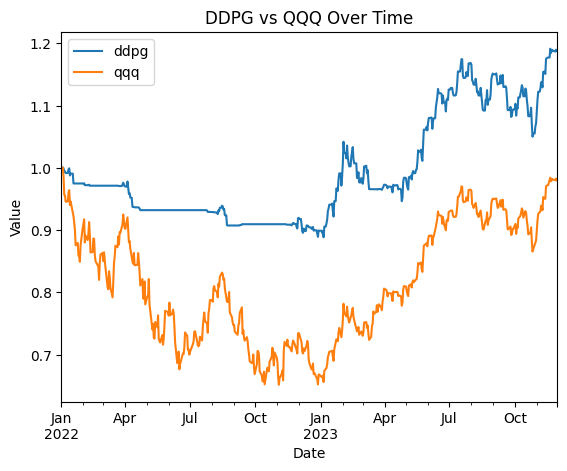

In [ ]:
qqq = get_baseline('QQQ', TEST_START_DATE, TEST_END_DATE)
qqq_init = qqq['close'][0]

### QQQ Baseline Stats
print('===================QQQ Baseline Stats================')
qqq_stats = backtest_stats(qqq, value_col_name = 'close')

# If 'date' is not the index, set it as the index for proper plotting
qqq.set_index('date', inplace=True)

ddpg_plot = df_account_value_tuned_ddpg.copy()

# Convert 'date' to datetime and set it as the index for the plotting DataFrame
ddpg_plot['date'] = pd.to_datetime(ddpg_plot['date'])
ddpg_plot.set_index('date', inplace=True)

if not isinstance(ddpg_plot.index, pd.DatetimeIndex):
    ddpg_plot.index = pd.to_datetime(ddpg_plot.index)

if not isinstance(qqq.index, pd.DatetimeIndex):
    qqq.index = pd.to_datetime(qqq.index)


# Plotting ddpg account value
ddpg_plot['account_value'].plot(label='ddpg')

# Plotting normalized qqq close value
(qqq['close'] / qqq_init).plot(label='qqq')

# Adding legend
plt.legend()

# Setting labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('DDPG vs QQQ Over Time')

# Display the plot
plt.show()

In [ ]:
#Hyperparamters importance
#Learning rate is the most important
plot_param_importances(study)

In [ ]:
#You can see with trial, our sharpe ratio is increasing
#Certainly you can afford more number of trials for further optimization
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

### Run Optuna for PPO

In [ ]:
def objective(trial:optuna.Trial):
  #Trial will suggest a set of hyperparamters from the specified range
  hyperparameters = sample_ppo_params(trial)
  model_ppo = agent.get_model("ppo",model_kwargs = hyperparameters,seed=42  ) #original FINRL parameters

  #You can increase it for better comparison
  trained_ppo = agent.train_model(model=model_ppo,
                                  tb_log_name="ppo" ,
                             total_timesteps=5000)
  trained_ppo.save('models/ppo_{}.pth'.format(trial.number))
  clear_output(wait=True)
  #For the given hyperparamters, determine the account value in the trading period
  df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)
  #Calculate sharpe from the account value
  sharpe = calculate_sharpe(df_account_value)

  return sharpe

#Create a study object and specify the direction as 'maximize'
#Goal is to maximize sharpe
#Pruner stops not promising iterations. Use a pruner, or you will get error related to divergence of model
#Can also use Multivariate sampler
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study_ppo = optuna.create_study(study_name="ppo_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=1e-5,patience=10,trial_number=30)

#You can increase the n_trials for a better search space scanning
study_ppo.optimize(objective, n_trials=20,catch=(ValueError,),callbacks=[logging_callback])
joblib.dump(study_ppo, "final_ppo_study__.pkl")

#Get the best hyperparamters
PPO_model_kwargs_tuned = study_ppo.best_params
print('Hyperparameters after tuning',PPO_model_kwargs_tuned)
study_ppo.best_trial

[I 2023-12-08 22:51:11,565] Trial 19 finished with value: 0.0 and parameters: {'n_steps': 5, 'ent_coef': 0.0001064901715302091, 'learning_rate': 0.003349291160691363, 'batch_size': 128}. Best is trial 17 with value: 0.6864496994091567.


hit end!
Hyperparameters after tuning {'n_steps': 5, 'ent_coef': 0.0001936936717785302, 'learning_rate': 0.0042799168123060375, 'batch_size': 128}


FrozenTrial(number=17, state=TrialState.COMPLETE, values=[0.6864496994091567], datetime_start=datetime.datetime(2023, 12, 8, 22, 48, 0, 11500), datetime_complete=datetime.datetime(2023, 12, 8, 22, 49, 4, 985169), params={'n_steps': 5, 'ent_coef': 0.0001936936717785302, 'learning_rate': 0.0042799168123060375, 'batch_size': 128}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_steps': CategoricalDistribution(choices=(5, 8, 16, 32, 64)), 'ent_coef': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.0001, step=None), 'batch_size': CategoricalDistribution(choices=(32, 64, 128, 256))}, trial_id=17, value=None)

In [ ]:
from stable_baselines3 import PPO
tuned_model_ppo = PPO.load('models/ppo_{}.pth'.format(study_ppo.best_trial.number),env=env_train)

#Trading period account value with tuned model
df_account_value_tuned_ppo, df_actions_tuned_ppo = DRLAgent.DRL_prediction(
    model=tuned_model_ppo,
    environment = e_trade_gym)

#Backtesting with our pruned model
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

#backtest stats calls get_daily_return which calls pyfolio perf stats
perf_stats_all_tuned_ppo = backtest_stats(account_value=df_account_value_tuned_ppo)
print('PPO Tuned Backtest Stats')
perf_stats_all_tuned_ppo = pd.DataFrame(perf_stats_all_tuned_ppo)
perf_stats_all_tuned_ppo.to_csv("./"+RESULTS_DIR+"/perf_stats_all_tuned_ppo"+now+'.csv')

hit end!
==============Get Backtest Results===========
Annual return          0.066339
Cumulative returns     0.194717
Annual volatility      0.101139
Sharpe ratio           0.686450
Calmar ratio           0.628857
Stability              0.546851
Max drawdown          -0.105491
Omega ratio            1.198858
Sortino ratio          1.057851
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.132958
Daily value at risk   -0.012467
dtype: float64
PPO Tuned Backtest Stats


===================QQQ Baseline Stats================
Annual return         -0.010842
Cumulative returns    -0.020592
Annual volatility      0.265630
Sharpe ratio           0.091497
Calmar ratio          -0.031129
Stability              0.130567
Max drawdown          -0.348280
Omega ratio            1.015139
Sortino ratio          0.129602
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.033743
Daily value at risk   -0.033370
dtype: float64


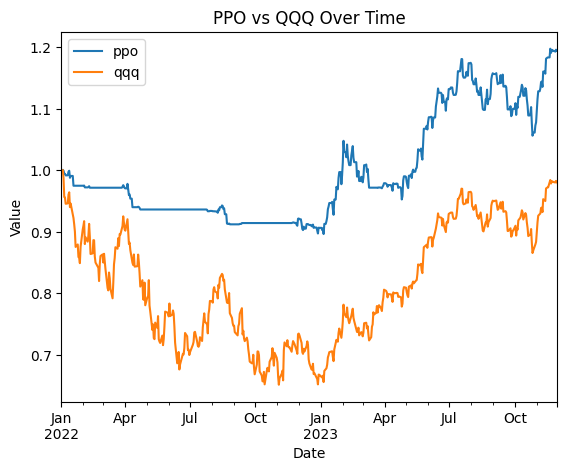

In [ ]:
### QQQ Baseline Stats
print('===================QQQ Baseline Stats================')
print(qqq_stats)

# If 'date' is not the index, set it as the index for proper plotting
ppo_plot = df_account_value_tuned_ppo.copy()

# Convert 'date' to datetime and set it as the index for the plotting DataFrame
ppo_plot['date'] = pd.to_datetime(ppo_plot['date'])
ppo_plot.set_index('date', inplace=True)

if not isinstance(ppo_plot.index, pd.DatetimeIndex):
    ppo_plot.index = pd.to_datetime(ppo_plot.index)


# Plotting ddpg account value
ppo_plot['account_value'].plot(label='ppo')

# Plotting normalized qqq close value
(qqq['close'] / qqq_init).plot(label='qqq')

# Adding legend
plt.legend()

# Setting labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('PPO vs QQQ Over Time')

# Display the plot
plt.show()

In [ ]:
#Hyperparamters importance
#Learning Rate is the most important
plot_param_importances(study_ppo)

In [ ]:
#You can see with trial, our sharpe ratio is increasing
#Certainly you can afford more number of trials for further optimization
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

### Run Optuna for A2C

In [ ]:
def objective(trial:optuna.Trial):
  #Trial will suggest a set of hyperparamters from the specified range
  hyperparameters = sample_a2c_params(trial)
  model_a2c = agent.get_model("a2c",model_kwargs = hyperparameters, seed=42  ) #original FINRL parameters

  #You can increase it for better comparison
  trained_a2c = agent.train_model(model=model_a2c,
                                  tb_log_name="a2c" ,
                             total_timesteps=5000)
  trained_a2c.save('models/a2c_{}.pth'.format(trial.number))
  clear_output(wait=True)
  #For the given hyperparamters, determine the account value in the trading period
  df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym)
  #Calculate sharpe from the account value
  sharpe = calculate_sharpe(df_account_value)

  return sharpe

#Create a study object and specify the direction as 'maximize'
#Goal is to maximize sharpe
#Pruner stops not promising iterations. Use a pruner, or you will get error related to divergence of model
#Can also use Multivariate sampler
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study_a2c = optuna.create_study(study_name="a2c_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=1e-5,patience=10,trial_number=30)

#You can increase the n_trials for a better search space scanning
study_a2c.optimize(objective, n_trials=10,catch=(ValueError,),callbacks=[logging_callback])
joblib.dump(study_a2c, "final_a2c_study__.pkl")

#Get the best hyperparamters
A2C_model_kwargs_tuned = study_a2c.best_params
print('Hyperparameters after tuning', A2C_model_kwargs_tuned)
study_a2c.best_trial

[I 2023-12-08 22:53:27,612] Trial 9 finished with value: 0.649694675035299 and parameters: {'n_steps': 64, 'ent_coef': 0.00016736010167825804, 'learning_rate': 0.8862326508576243}. Best is trial 3 with value: 0.649694675035299.


hit end!
Hyperparameters after tuning {'n_steps': 64, 'ent_coef': 0.0003972110727381913, 'learning_rate': 0.011400863701127324}


FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.649694675035299], datetime_start=datetime.datetime(2023, 12, 8, 22, 51, 53, 125763), datetime_complete=datetime.datetime(2023, 12, 8, 22, 52, 5, 241020), params={'n_steps': 64, 'ent_coef': 0.0003972110727381913, 'learning_rate': 0.011400863701127324}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_steps': CategoricalDistribution(choices=(5, 8, 16, 32, 64)), 'ent_coef': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.0001, step=None)}, trial_id=3, value=None)

In [ ]:
from stable_baselines3 import A2C
tuned_model_a2c = A2C.load('models/a2c_{}.pth'.format(study_a2c.best_trial.number),env=env_train)

#Trading period account value with tuned model
df_account_value_tuned_a2c, df_actions_tuned_a2c = DRLAgent.DRL_prediction(
    model=tuned_model_a2c,
    environment = e_trade_gym)

#Backtesting with our pruned model
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

#backtest stats calls get_daily_return which calls pyfolio perf stats
perf_stats_all_tuned_a2c = backtest_stats(account_value=df_account_value_tuned_a2c)
print('A2C Tuned Backtest Stats')
perf_stats_all_tuned_a2c = pd.DataFrame(perf_stats_all_tuned_a2c)
perf_stats_all_tuned_a2c.to_csv("./"+RESULTS_DIR+"/perf_stats_all_tuned_a2c"+now+'.csv')

hit end!
==============Get Backtest Results===========
Annual return          0.063534
Cumulative returns     0.186034
Annual volatility      0.103108
Sharpe ratio           0.649695
Calmar ratio           0.554082
Stability              0.513147
Max drawdown          -0.114665
Omega ratio            1.185004
Sortino ratio          1.000657
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.099004
Daily value at risk   -0.012725
dtype: float64
A2C Tuned Backtest Stats


===================QQQ Baseline Stats================
Annual return         -0.010842
Cumulative returns    -0.020592
Annual volatility      0.265630
Sharpe ratio           0.091497
Calmar ratio          -0.031129
Stability              0.130567
Max drawdown          -0.348280
Omega ratio            1.015139
Sortino ratio          0.129602
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.033743
Daily value at risk   -0.033370
dtype: float64


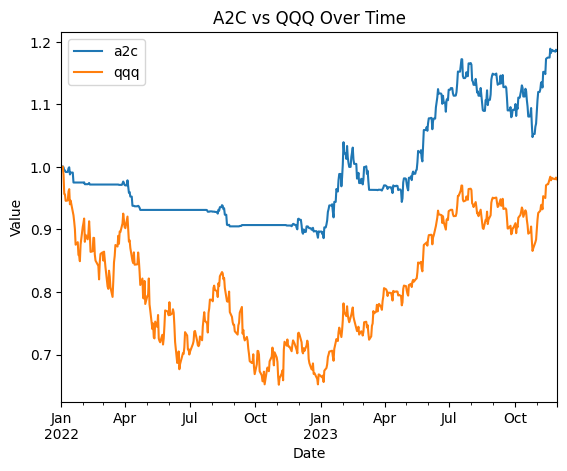

In [ ]:
### QQQ Baseline Stats
print('===================QQQ Baseline Stats================')
print(qqq_stats)

# If 'date' is not the index, set it as the index for proper plotting
a2c_plot = df_account_value_tuned_a2c.copy()

# Convert 'date' to datetime and set it as the index for the plotting DataFrame
a2c_plot['date'] = pd.to_datetime(a2c_plot['date'])
a2c_plot.set_index('date', inplace=True)

if not isinstance(a2c_plot.index, pd.DatetimeIndex):
    a2c_plot.index = pd.to_datetime(a2c_plot.index)

# Plotting ddpg account value
a2c_plot['account_value'].plot(label='a2c')

# Plotting normalized qqq close value
(qqq['close'] / qqq_init).plot(label='qqq')

# Adding legend
plt.legend()

# Setting labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('A2C vs QQQ Over Time')

# Display the plot
plt.show()

In [ ]:
#Hyperparamters importance
#Learning Rate is the most important
plot_param_importances(study_a2c)

In [ ]:
#You can see with trial, our sharpe ratio is increasing
#Certainly you can afford more number of trials for further optimization
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

# Ensemble DRL Algorithm Implementation with Tuned Hyperparameters from Optuna

In [ ]:
#Environment for DRLEnsembleAgent
env_kwargs = {
    "hmax": 1, #1 to match original action scaling of 1
    "initial_amount": 1, #we divided the close price of the stock by 10,000. Which means this is equivalent to $10,000 starting value.
    "buy_cost_pct": 0.00001, #modify
    "sell_cost_pct": 0.00001, #modify
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4, #modify,
    "columns_norm": columns_norm,
    "print_verbosity":500
}

rebalance_window = 63 # rebalance_window is the number of days/time block to retrain the model
validation_window = 63 # validation_window is the number of days/time block to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

#Tuned Parameters from Previous Section
timesteps_dict = {'a2c' : 5_000,
                 'ppo' : 5_000,
                 'ddpg' : 5_000
                 }
#check dates of the data passed into the ensemble agent
print(processed.head())
print(processed.tail())

#Instantiate DRLEnsembleAgent
ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)
print('Test Start Date', TEST_START_DATE, '\nTest End DAte', TEST_END_DATE)

#Call run_ensemble_strategy and pass in model arguments
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs_tuned,
                                                 PPO_model_kwargs_tuned,
                                                 DDPG_model_kwargs_tuned,
                                                 timesteps_dict)
df_summary

Streaming output truncated to the last 5000 lines.
|    entropy_loss         | 1.48      |
|    explained_variance   | -48.6     |
|    learning_rate        | 0.00428   |
|    loss                 | 0.314     |
|    n_updates            | 7500      |
|    policy_gradient_loss | 0.299     |
|    reward               | 0.0       |
|    std                  | 0.0551    |
|    value_loss           | 5.42e-05  |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 80         |
|    iterations           | 752        |
|    time_elapsed         | 46         |
|    total_timesteps      | 3760       |
| train/                  |            |
|    approx_kl            | 0.08492599 |
|    clip_fraction        | 0.48       |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.48       |
|    explained_variance   | -41.4      |
|    learning_rate        | 0.00428    |
|    loss       

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2022-01-02,2022-03-06,PPO,-0.211676,0.0,0.0
1,189,2022-03-06,2022-05-08,PPO,0.0,0.0,-0.219077
2,252,2022-05-08,2022-07-10,DDPG,0.0,-0.022796,0.0
3,315,2022-07-10,2022-09-11,DDPG,0.025016,0.0,0.025016
4,378,2022-09-11,2022-11-13,PPO,0.0,0.087093,0.087093
5,441,2022-11-13,2023-01-15,PPO,0.0,0.0,-0.033985
6,504,2023-01-15,2023-03-19,A2C,0.124109,0.0,0.0
7,567,2023-03-19,2023-05-21,A2C,0.352245,0.314881,0.0
8,630,2023-05-21,2023-07-23,A2C,0.313676,0.0,0.0
9,693,2023-07-23,2023-09-24,PPO,0.0,0.0,-0.165987


# Backtest Strategy

In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()
print(TEST_START_DATE, TEST_END_DATE)
print(processed.date.tail())

2022-01-01 2023-12-01
2153    2023-11-25
2154    2023-11-26
2155    2023-11-27
2156    2023-11-28
2157    2023-11-29
Name: date, dtype: object


In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

print('trade date len',len(unique_trade_date))
df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    #print(temp)
    df_account_value = df_account_value._append(temp,ignore_index=True) #replaced append with concat
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
print('df_account_value', df_account_value)

trade date len 697
Sharpe Ratio:  0.8145846346260758
df_account_value      account_value        date  daily_return    datadate
0         1.000000  2022-03-06           NaN  2022-03-06
1         1.000000  2022-03-07           0.0  2022-03-07
2         1.000000  2022-03-08           0.0  2022-03-08
3         1.000000  2022-03-09           0.0  2022-03-09
4         1.000000  2022-03-10           0.0  2022-03-10
..             ...         ...           ...         ...
625       1.299495  2023-11-21           0.0  2023-11-21
626       1.299495  2023-11-22           0.0  2023-11-22
627       1.299495  2023-11-23           0.0  2023-11-23
628       1.299495  2023-11-24           0.0  2023-11-24
629       1.299495  2023-11-25           0.0  2023-11-25

[630 rows x 4 columns]


In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.0,2022-03-06,NaN,2022-03-06
1,1.0,2022-03-07,0.0,2022-03-07
2,1.0,2022-03-08,0.0,2022-03-08
3,1.0,2022-03-09,0.0,2022-03-09
4,1.0,2022-03-10,0.0,2022-03-10


In [ ]:
df_account_value.tail()

,account_value,date,daily_return,datadate
625,1.299495,2023-11-21,0.0,2023-11-21
626,1.299495,2023-11-22,0.0,2023-11-22
627,1.299495,2023-11-23,0.0,2023-11-23
628,1.299495,2023-11-24,0.0,2023-11-24
629,1.299495,2023-11-25,0.0,2023-11-25


<Axes: >

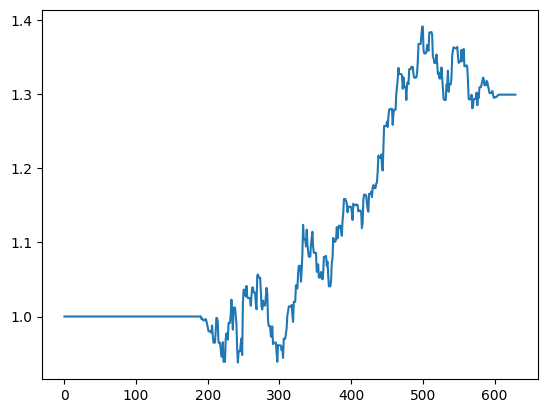

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

## Backtest Stats

In [ ]:
#Ensemble Agent Backteste Results
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.110478
Cumulative returns     0.299495
Annual volatility      0.140963
Sharpe ratio           0.814585
Calmar ratio           0.989477
Stability              0.782187
Max drawdown          -0.111652
Omega ratio            1.227937
Sortino ratio          1.325985
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.199175
Daily value at risk   -0.017304
dtype: float64


## Backtest Plot

In [ ]:
### QQQ Baseline Stats
print('===================QQQ Baseline Stats================')
print(qqq_stats)

===================QQQ Baseline Stats================
Annual return         -0.010842
Cumulative returns    -0.020592
Annual volatility      0.265630
Sharpe ratio           0.091497
Calmar ratio          -0.031129
Stability              0.130567
Max drawdown          -0.348280
Omega ratio            1.015139
Sortino ratio          0.129602
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.033743
Daily value at risk   -0.033370
dtype: float64


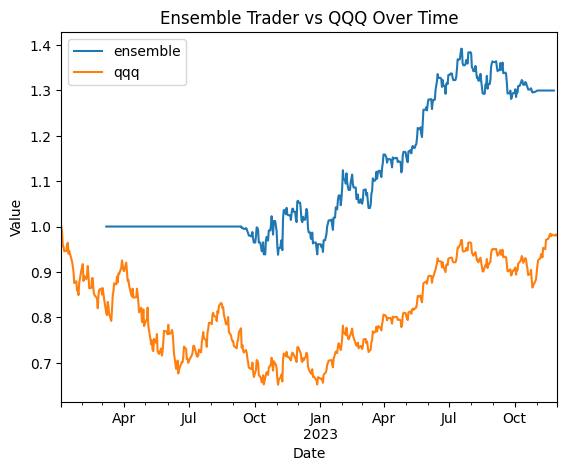

In [ ]:
# If 'date' is not the index, set it as the index for proper plotting
ensemble_plot = df_account_value.copy()

# Convert 'date' to datetime and set it as the index for the plotting DataFrame
ensemble_plot['date'] = pd.to_datetime(ensemble_plot['date'])
ensemble_plot.set_index('date', inplace=True)

if not isinstance(ensemble_plot.index, pd.DatetimeIndex):
    ensemble_plot.index = pd.to_datetime(ensemble_plot.index)

#Define start date as when ensemble took place
start_date = ensemble_plot['daily_return'].first_valid_index()

# Plotting ddpg account value
ensemble_plot = ensemble_plot[start_date:]

# Plotting ensemble account value
ensemble_plot['account_value'].plot(label='ensemble')

# Plotting normalized qqq close value
(qqq['close'] / qqq_init).plot(label='qqq')

# Adding legend
plt.legend()

# Setting labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Ensemble Trader vs QQQ Over Time')

# Display the plot
plt.show()